## True Rosenbrock Posterior Calculation Using Emcee 

---

David P. Fleming, 2018

This notebook demonstrates how to use the Metropolis-Hastings MCMC algorithm to derive the posterior distribution for the Rosenbrock function example presented in Wang & Li (2017) using emcee.

See https://emcee.readthedocs.io/en/stable/ for more information on emcee.

In [1]:
%matplotlib inline

from approxposterior import likelihood as lh
from approxposterior import mcmc_utils

import numpy as np
import emcee
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

**Set up MCMC initial conditions**

---

In [3]:
ndim = 2          # Number of dimensions
nsteps = 20000    # Number of MCMC iterations
verbose = False   # Don't output lots of stuff

nwalk = 10 * ndim # Use 10 walkers per dimension

# Initial guess for walkers (random over prior)
p0 = [lh.rosenbrock_sample(1) for j in range(nwalk)]

**Initialize MCMC Ensemble Sampler object**

---

Note that here, we use the ```lh.rosenbrock_lnprob``` function that computes the log-likelihood plus the log-prior for the Rosenbrock function model as described in Wang & Li (2017).  The functions used to compute this example is provided in ```approxposterior```. See ```example.py``` in ```approxposterior```'s ```examples``` directory for to see how ```approxposterior```'s BAPE algorithm approximates the Rosenbrock function posterior derived in this notebook.

In [4]:
sampler = emcee.EnsembleSampler(nwalk, ndim, lh.rosenbrock_lnprob)

**Run the MCMC!**

---

After the MCMC run finishes, we estimate the burn in time (meh explaination: the burn in is the time at which the chains are sufficiently uncorrelated such that subsequent MCMC iterations sample from the true posterior distribution).  We estimate the burn in time by finding the longest autocorrelation time out of all the chains.  This tends to be a rather conservative estimate and it seems to work well in practice.

In [5]:
for i, result in enumerate(sampler.sample(p0, iterations=nsteps)):
    if verbose:
        print("%d/%d" % (i+1, nsteps))
                
print("emcee finished!")

emcee finished!


In [6]:
iburn = mcmc_utils.estimate_burnin(sampler, nwalk, nsteps, ndim)
print(iburn)

1001


A not-terrible rule of thumb is for your total number of MCMC iterations to be 10x your burn in, so this looks fine. 

**Let's visually inspect the chains to see if they're converged.**

---

The blue dashed line corresponds to our burn in estimate.

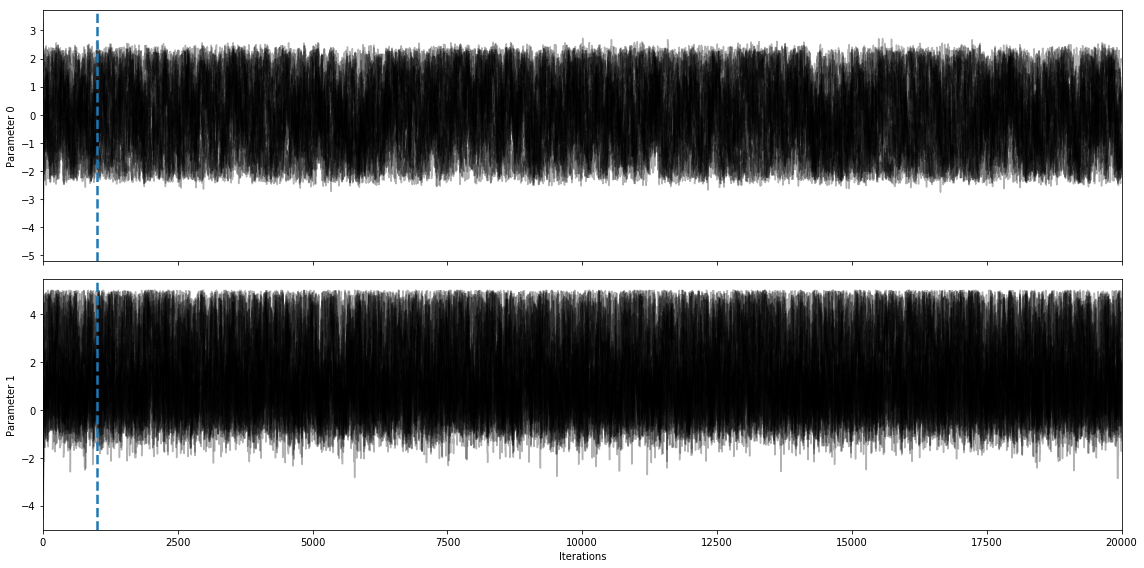

In [7]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(16,8))

# Plot allllll the walkers and chains
ax[0].plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3);
ax[1].plot(sampler.chain[:,:,1].T, '-', color='k', alpha=0.3);

# Plot where the burn in is
ax[0].axvline(iburn, ls="--", color="C0", lw=2.5)
ax[1].axvline(iburn, ls="--", color="C0", lw=2.5)

# Formatting
ax[0].set_xlim(0,nsteps)
ax[1].set_xlim(0,nsteps)
ax[0].set_ylabel("Parameter 0")
ax[1].set_ylabel("Parameter 1")
ax[1].set_xlabel("Iterations")

fig.tight_layout()

**Looks good!  Let's plot the joint and marginal posterior distributions.**

---

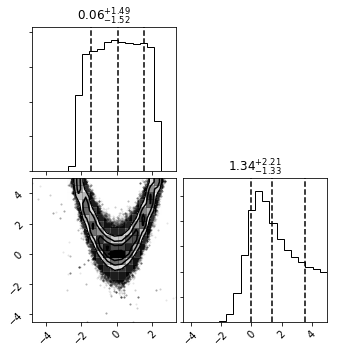

In [8]:
fig = corner.corner(sampler.flatchain[iburn:],
                    quantiles=[0.16, 0.5, 0.84],
                    plot_contours=True, show_titles=True);

fig.savefig("true_post.pdf", bbox_inches="tight")

Neat.  Now let's save the sampler object and burn in time into a numpy archive so we can compare our approximate distributions with the truth derived here to see how accurate ```approxposterior``` (in another notebook...)!

In [9]:
np.savez("true_rosenbrock.npz", 
         flatchain=sampler.flatchain,
         iburn=iburn)